In [15]:
import numpy as np
import pandas as pd
from PIL import Image # Pytorch Image Library
import matplotlib.pyplot as plt
from glob import glob
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset

import torchvision
import torchvision.transforms as transforms

# Preparing Dataset
1. preparing dataset class
2. preparing Sampler
3. preparing DataLoader

## 1. preparing dataset class

In [5]:
class InValidDatasetException(Exception):
    
    def __init__(self, len_of_paths, len_of_lables):
        super().__init__(f"Number of paths ({len_of_paths})is not compatible with number of lables({len_of_labels})")
                         

In [8]:
transform = transforms.Compose([transforms.ToTensor()])

In [9]:
class AnimalDataset(Dataset):
    
    def __init__(self, img_paths, img_labels, size_of_images):
        self.img_paths = img_paths
        self.img_labels = img_labels
        self.size_of_images = size_of_images
        if len(self.img_paths) != len(self.img_labels):
            raise InValidDatasetException(self.img_paths, self.img_labels) # path와 label의 길이가 같지 않으면 에러
    
    # override
    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, index):
        # img의 크기를 정해놓은 크기로 조정
        PIL_IMAGE = Image.open(self.img_paths[index]).resize(self.size_of_images)
        # 이미지를 텐서로 바꿈
        TENSOR_IMAGE = transform(PIL_IMAGE)
        # 이미지의 라벨은 원래 라벨 그대로
        label = self.img_labels[index]
        
        # 텐서로 바꾼 이미지와 그 라벨 반환
        return TENSOR_IMAGE, label

In [21]:
paths = []
labels = []
label_map = {0:'Cat', 1:'Dog', 2:'Wild'}

# *은 경로 안의 모든 파일을 의미 
cat_paths = glob("/kaggle/input/animal-faces/afhq/train/cat/*") + glob("/kaggle/input/animal-faces/afhq/val/cat/*")
dog_paths = glob("/kaggle/input/animal-faces/afhq/train/dog/*") + glob("/kaggle/input/animal-faces/afhq/val/dog/*")
wild_paths = glob("/kaggle/input/animal-faces/afhq/train/wild/*") + glob("/kaggle/input/animal-faces/afhq/val/wild/*")

for cat_path in cat_paths:
    paths.append(cat_path)
    labels.append(0)

for dog_path in dog_paths:
    paths.append(dog_path)
    labels.append(1)
    
for wild_path in wild_paths:
    paths.append(wild_path)
    labels.append(2)
    
print(len(paths))
print(len(labels))

16130
16130


In [23]:
dataset = AnimalDataset(paths, labels, (250, 250))

## 2. preparing Sampler

In [25]:
from sklearn.model_selection import train_test_split

# dataset의 인덱스
dataset_indices = list(range(0, len(dataset)))

train_indices, test_indices = train_test_split(dataset_indices, test_size = 0.2, random_state = 42)

print(f"Number of train samples: {len(train_indices)}")
print(f"Number of test samples: {len(test_indices)}")

Number of train samples: 12904
Number of test samples: 3226


In [27]:
# train_indices와 test_indices에서 무작위로 부분집합을 생성
train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)

## 3. preparing Data Loader

In [29]:
BATCH_SIZE = 128
# train_sampler: 어떤 128개의 데이터를 고를 것이냐? -> 무작위로 선택 
train_loader = torch.utils.data.DataLoader(dataset, batch_size = BATCH_SIZE, sampler = train_sampler)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size = BATCH_SIZE, sampler = test_sampler)

In [46]:
print(len(train_loader))

101


In [30]:
# 128개의 배치
# 그 중 1번째 (img, label)
# 그 중 0번째 idx: img 
# img.shape = (3, 250, 250): (#channel, height, width)
dataset[1][0].shape

torch.Size([3, 250, 250])

In [35]:
# train_loader를 반복 가능한 객체로 만들어 img, label을 반복적으로 불러옴
images, labels = next(iter(train_loader))
type(labels)

torch.Tensor

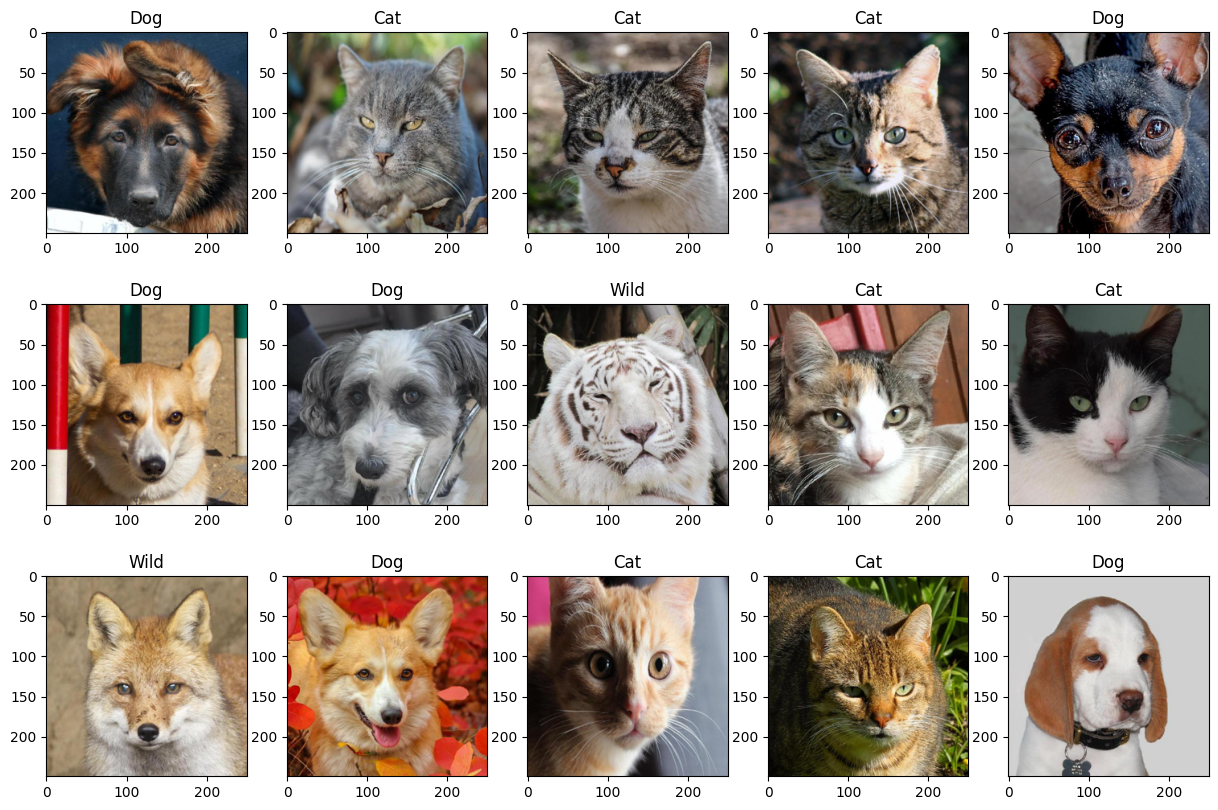

In [39]:
# .next() 메서드보다 관습적으로 아래 방식을 더 선호함
images, labels = next(iter(train_loader))

fig, axis = plt.subplots(3, 5, figsize = (15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        npimg = images[i].numpy() # img를 numpy로 변환
        npimg = np.transpose(npimg, (1, 2, 0)) # img의 차원을 변환
        label = label_map[int(labels[i])]
        ax.imshow(npimg)
        ax.set(title = f"{label}")

# Neural Network Modeling

In [57]:
class CNN(nn.Module):
    
    def __init__(self):
        super(CNN, self).__init__()
        
        # 입력 채널 수: 3(RGB)
        # 다음 채널 수 : 32개
        # 하나의 배치(128)를 받아 하나의 img씩 처리 
        self.conv1 = nn.Conv2d(3, 32, kernel_size = 3, stride = 2, padding = 1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size = 3, stride = 2, padding = 1)
        self.batchnorm1 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size = 3, stride = 2, padding = 1)
        self.batchnorm2 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size = 3, stride = 2, padding = 1)
        self.batchnorm3 = nn.BatchNorm2d(256)
        self.maxpool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256*2*2, 512)
        self.fc2 = nn.Linear(512, 3)
        # 3개의 클래스(cat, dog, wild)일 확률
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.batchnorm1(x) # 배치 정규화를 통해 hidden layer의 input과 output의 scale(평균과 분산)을 맞춰준다. 
        x = self.maxpool(x)
        x = F.relu(self.conv3(x))
        x = self.batchnorm2(x)
        x = self.maxpool(x)
        x = F.relu(self.conv4(x))
        x = self.batchnorm3(x)
        x = self.maxpool(x)
        x = x.view(-1, 256*2*2)
        x = self.fc1(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim = 1)
        # x.shape = (128, 3)
        
        return x
        

In [52]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [58]:
# cpu이므로 바꿀 필요 없음
model = CNN()

In [59]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr = 1e-4)

# Training model

In [61]:
EPOCH = 2
TRAIN_LOSS = []
TRAIN_ACCURACY = []

for epoch in range(1, EPOCH + 1):
    epoch_loss = 0
    correct = 0
    total = 0
    
    # 한 epoch당 하나의 batch를 훈련함
    # enumerate를 사용하면 idx, (data, target)이 반환됨
    # 사용하지 않으면 (data, target)이 반환됨
    # train_loader는 한 번에 128개의 이미지를 가져옴
    # len(train_loader) = len(train_data) / len(BATCH_SIZE) = 101
    for data, target in train_loader:
        
        img = data
        label = target
        
        optimizer.zero_grad()
        
        outputs = model(img)
        loss = criterion(outputs, label)
        
        loss.backward()
        optimizer.step()
        
        # loss는 텐서의 단일 값, item()은 이를 스칼라로 바꿔줌
        epoch_loss += loss.item()
        _, pred = torch.max(outputs, dim = 1) # 행에서 제일 큰 value를 (value, idx)로 반환
        correct += torch.sum(pred == label).item() # pred == label인 것들의 개수를 세서 스칼라로 반환, 128개 중에 몇 개를 맞췄나
        total += label.size(0) # label.shape = (128, 1), 한 번의 반복문마다 batch_size를 누적
        
        
    TRAIN_LOSS.append(epoch_loss)
    TRAIN_ACCURACY.append(100*correct/total)
    print(f"Epoch: {epoch} | Accuracy: {100*correct/total} | Loss: {epoch_loss}")


Epoch: 1 | Accuracy: 96.20272783632981 | Loss: 11.565818876028061
Epoch: 2 | Accuracy: 98.48109113453192 | Loss: 5.393158249557018


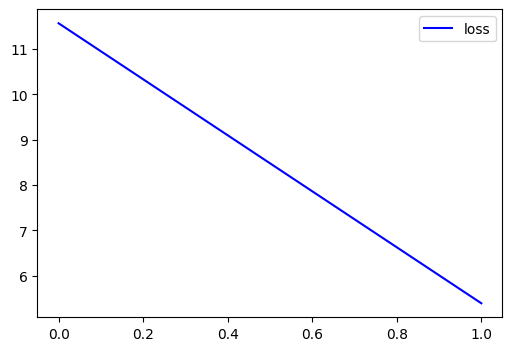

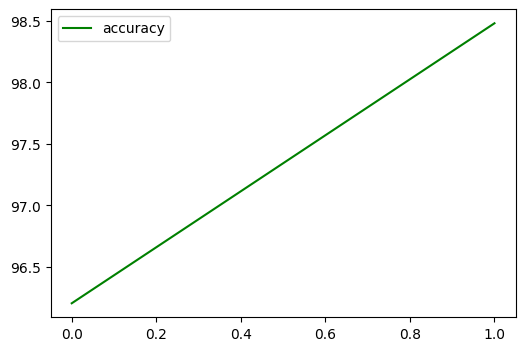

In [62]:
plt.subplots(figsize = (6, 4))
plt.plot(range(EPOCH), TRAIN_LOSS, color = 'blue', label = 'loss')
plt.legend()
plt.show()

plt.subplots(figsize = (6, 4))
plt.plot(range(EPOCH), TRAIN_ACCURACY, color = 'green', label = 'accuracy')
plt.legend()
plt.show()

# Final test

In [65]:
total_val_loss = 0.0
total_true = 0
total = len(test_sampler)

with torch.no_grad():
    model.eval()
    # len(validation_loader) = len(test_data) / 128
    for data, target in validation_loader:
        img = data
        label = target
        
        outputs = model(img)
        loss = criterion(outputs, label).item()
        
        _, preds = torch.max(outputs, dim = 1)
        total_val_loss += loss
        true = torch.sum(preds == label).item()
        total_true += true
        
validation_accuracy = round(100*total_true/total, 2)
print(f"Validation accuracy: {validation_accuracy}%")
print(f"Validation loss: {round(total_val_loss, 2)}%")

Validation accuracy: 92.99%
Validation loss: 4.92%


In [66]:
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

conv1.weight 	 torch.Size([32, 3, 3, 3])
conv1.bias 	 torch.Size([32])
conv2.weight 	 torch.Size([64, 32, 3, 3])
conv2.bias 	 torch.Size([64])
batchnorm1.weight 	 torch.Size([64])
batchnorm1.bias 	 torch.Size([64])
batchnorm1.running_mean 	 torch.Size([64])
batchnorm1.running_var 	 torch.Size([64])
batchnorm1.num_batches_tracked 	 torch.Size([])
conv3.weight 	 torch.Size([128, 64, 3, 3])
conv3.bias 	 torch.Size([128])
batchnorm2.weight 	 torch.Size([128])
batchnorm2.bias 	 torch.Size([128])
batchnorm2.running_mean 	 torch.Size([128])
batchnorm2.running_var 	 torch.Size([128])
batchnorm2.num_batches_tracked 	 torch.Size([])
conv4.weight 	 torch.Size([256, 128, 3, 3])
conv4.bias 	 torch.Size([256])
batchnorm3.weight 	 torch.Size([256])
batchnorm3.bias 	 torch.Size([256])
batchnorm3.running_mean 	 torch.Size([256])
batchnorm3.running_var 	 torch.Size([256])
batchnorm3.num_batches_tracked 	 torch.Size([])
fc1.weight 	 torch.Size([512, 1024])
fc1.bias 	 torch.Size([512])
fc2.weight 	 torch.